In [73]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
cm = 1/2.54  # centimeters in inches
main_font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

tick_font = {'fontname':'Arial', 'weight':'normal', 'size':8}

matplotlib.rc('font', **main_font)

import scipy.stats
import scikit_posthocs as sp
import numpy as np

In [3]:
def box_violin(data, position, color, ax):

    if not isinstance(position, list):
        position = [position]
    #plot violin
    parts = ax.violinplot(data, positions=position, vert=False,
                showmeans=False, showmedians=False,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.4)

    # plot boxplot
    ax.boxplot(data, positions=position, vert=False,
               showmeans=False, meanline=False, patch_artist=True,
               boxprops=dict(facecolor=color, color='k', linewidth=0.5),
               medianprops=dict(color='k' ),
               whiskerprops=dict(linewidth=0.5),
               flierprops =dict(markersize=1, marker='o'),
               # meanprops=dict(color='k',linestyle = ':')
               )

def add_table_line(y, text_info, values,
        include_info,
        include_stats):

    d = values.describe()
    d['IQR'] = d['75%']-d['25%']

    x_list_1 = [-0.2 * (i+1)  for i in range(len(include_stats ))]
#     x_list_2 = [-0.15 * (i) + min(x_list_1)-0.15 for i in range(len(include_info))]
    if include_info:
        x_list_2 = [ i+min(x_list_1) for i in [-0.55]]#, -0.47, -.75] ] 
    else:
        x_list_2 = []
    x_list =  x_list_2 + x_list_1
    text = include_info[::-1]+include_stats[::-1]

    if y==0:
        for x, t in zip(x_list, text):
            t = t.replace('Normalisation', 'Norm      T')\
                 .replace('Learning_rate', 'LR')\
                 .replace('50%', 'M')\
                 .replace('Loss', 'LF')

            plt.text(x, y-0.5, t, fontweight='bold')

    for x,s  in zip(x_list_1[::-1], include_stats):
        plt.text(x, y,'{:.2f}'.format(d[s]), va='center')

    for x,s  in zip(x_list_2[::-1], include_info):

        t = text_info[s]

        if isinstance(t, float):
            t = '{:.0e}'.format(t)
        else:
            t = t.replace('Z-Score', 'ZS').replace(' ','').replace('ModifiedDiceLoss', 'mDL')\
                                                            .replace('BinaryFbetaLoss', 'DL')
            t= t.replace('_', ' ').replace('onLARC', '  C2').replace('onOxy', '  C1')
            t= t.replace('both on MIXED', '  C1/C2')
            t = t.replace('both on Oxy', '  C1')
        plt.text(x, y, t, va='center')

def plot_experiment(src, id_0, result, position, row_info, n_fold=5, color='#ff8c00',
    include_info = ['Dataset', 'Channels', 'Normalisation','Learning_rate', 'Loss'],
    include_stats = ['50%', 'IQR']):
#     marker_folds = ['v', '<', '^', '>', 'D']
    marker_folds = ['x']*5

    prefix, idx = id_0.split('_')
    idx = int(idx)

    f_comb = prefix + '_' + '_'.join([str(i) for i in range(idx, idx+n_fold)]) +'_'+result+'.csv'
    
    if os.path.isfile(os.path.join(src,f_comb)):
        main_data = pd.read_csv(os.path.join(src,f_comb))['f1_score']
    else:
        print('missing data')
        main_data = pd.Series([1,1,1,1])
    
    
    box_violin(main_data.to_list(),position,color, plt.gca())


    for i, p in zip(range(n_fold), [-0.2,-0.1, 0, .1, .2]):
        f = os.path.join(src,prefix+'_'+str(i+idx), result+'.csv')
        if os.path.isfile(f):
            fold_data= pd.read_csv(f)['f1_score']
        else:
            print('Missing')
            fold_data= pd.Series([1,1,1,1])
        m = fold_data.describe()['50%']
        plt.plot(m, position+p, marker_folds[i]+'k', zorder=5000, 
                 markersize=1.5, 
                 markeredgecolor= 'k', #636363', 
                 markeredgewidth=0.5,
                ) 
    
    add_table_line(position, row_info, main_data, include_info, include_stats)
    

In [3]:
def friedmann_test(src, id_0_list):
    n_fold=5
    
    data = []
    for id_0 in id_0_list:
        prefix, idx = id_0.split('_')
        idx = int(idx)
        result = 'patient'

        f_comb = prefix + '_' + '_'.join([str(i) for i in range(idx, idx+n_fold)]) +'_'+result+'.csv'
    
        main_data = pd.read_csv(os.path.join(src,f_comb))['f1_score']

        data.append(main_data.to_list())
    

    # friedman test
    result = scipy.stats.friedmanchisquare(*data)
    
    print(result)
    print('pvalue < 0.0001', result.pvalue < 0.0001)
    
    # find highest rank sum 
    ranks = scipy.stats.rankdata(data).reshape(len(data),len(data[0]))
    result_ranks = np.array([p.sum() for p in ranks])
    highest_rank = np.argmax(result_ranks)
    print(result_ranks, highest_rank, id_0_list.to_list()[highest_rank])

    return id_0_list.to_list()[highest_rank]

FriedmanchisquareResult(statistic=8.901408450704253, pvalue=0.011670345522674116)
pvalue < 0.0001 False
[6614. 7772. 8405.] 2 bigart_105
FriedmanchisquareResult(statistic=9.533742331288295, pvalue=0.008506955417858288)
pvalue < 0.0001 False
[40166. 41618. 38021.] 1 bigart_120


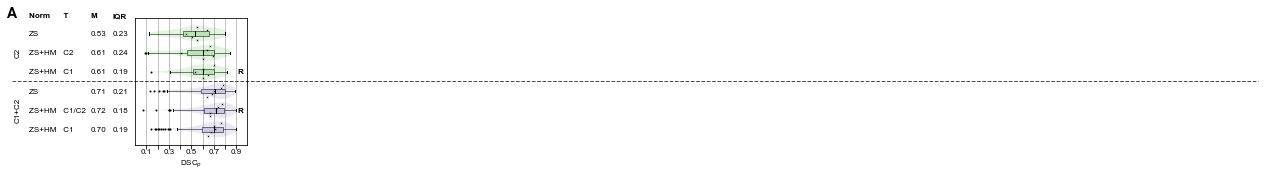

In [4]:
src = r'D:\BiGART_results'
df = pd.read_csv('experiments.csv')
df.drop_duplicates(subset=df.columns.difference(
                                ['ID','validation_fold', 'Status']),
                                keep='first', inplace=True)
df = df.loc[df['Dataset'].isin(['LARC', 'Oxy+LARC'])]
df = df.loc[df['Loss'].isin(['BinaryFbetaLoss'])]

df.sort_values(['Dataset', 'Normalisation', 'Loss', 'Learning_rate', ], inplace=True)

# print(df)

include_info = ['Normalisation']

fig, ax = plt.subplots(1,1, figsize= (9*cm , 6*cm))


colors = {'LARC': '#bae4b3', 
          'Oxy+LARC': '#cbc9e2'}
ranks= [ friedmann_test(src, df.loc[df['Dataset'].isin(['LARC'])]['ID'] ),
         friedmann_test(src, df.loc[df['Dataset'].isin(['Oxy+LARC'])]['ID'] )
       ]   
 

for idx, (_, e) in enumerate(df.iterrows()):
    plot_experiment(src, e['ID'], 'patient', idx*0.6, e,  color=colors[e['Dataset']], include_info=include_info)
    
    if e['ID'] in ranks:
        plt.text(0.94, idx*0.6, 'R', weight='bold', va='center', ha='center')
    

plt.text(-1.05, 0.6,'C2', va= 'center', ha='center', rotation=90)
plt.text(-1.05,2.4,'C1+C2', va= 'center', ha='center', rotation=90)

plt.text(-1.05, -0.5, 'A', fontweight='bold', fontsize=14, ha='right')

ax.set_ylim(ax.get_ylim()[::-1])
ax.set(xlim=[0,1], 
       xlabel='DSC$_p$',
       xticks=[0.1*i for i in range(1,10)],
       xticklabels=[0.1, '', 0.3, '', 0.5 , '', 0.7, '', 0.9],
       yticks=[],
      )
#     ax.minorticks_on()
ax.grid(which='major', color='#666666', linestyle='-', axis='x', alpha=0.5)
plt.plot([-1.1, 10] , [1.5]*2, 'k--', clip_on=False, linewidth=1, alpha=0.7)





ax.tick_params(axis='x', which='major', pad=0)
plt.subplots_adjust(left=0.55, bottom=0.15, right=0.99, top=0.90, wspace=None, hspace=None)




plt.savefig('..\Paper_2\gfx\Fig_3A.png', dpi=300)

FriedmanchisquareResult(statistic=35.625754527162826, pvalue=3.2589034854135038e-06)
pvalue < 0.0001 True
          0   1      2   3   4         5         6
0        ns  ns     ns  ns  ns  0.031105  0.044178
1        ns  ns     ns  ns  ns        ns        ns
2        ns  ns     ns  ns  ns     0.001     0.001
3        ns  ns     ns  ns  ns        ns        ns
4        ns  ns     ns  ns  ns        ns        ns
5  0.031105  ns  0.001  ns  ns        ns        ns
6  0.044178  ns  0.001  ns  ns        ns        ns


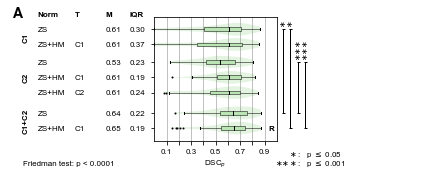

In [84]:
def box_violin(data, position, color, ax):

    if not isinstance(position, list):
        position = [position]
    #plot violin
    parts = ax.violinplot(data, positions=position, vert=False,
                showmeans=False, showmedians=False,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.4)

    # plot boxplot
    ax.boxplot(data, positions=position, vert=False,
               showmeans=False, meanline=False, patch_artist=True,
               boxprops=dict(facecolor=color, color='k', linewidth=0.5),
               medianprops=dict(color='k' ),
               whiskerprops=dict(linewidth=0.5),
               flierprops =dict(markersize=1, marker='o'),
               # meanprops=dict(color='k',linestyle = ':')
               )


def get_LARC_patients(file):
    df = pd.read_csv(file)
    d = df.loc[df['patient_ids'] < 1000]['f1_score']
    s = d.describe()
    
    M = s['50%']
    IQR = s['75%']-s['25%']
    
    return M, IQR, d

src = r'D:\BiGART_results'
data = [[     '',    'ZS',   '', 'voted_55_test_LARC_ZScore.csv'  ],
        [   'C1', 'ZS+HM', 'C1', 'voted_55_test_LARC_MHZScore_onOxy.csv'],
#         [     '', 'ZS+HM', 'C2', 'voted_55_test_LARC_MHZScore_onLARC.csv'],
        
        [     '',    'ZS',   '', 'bigart_95_96_97_98_99_patient.csv'],
        [   'C2', 'ZS+HM', 'C1', 'bigart_105_106_107_108_109_patient.csv'], 
        [     '', 'ZS+HM', 'C2', 'bigart_100_101_102_103_104_patient.csv'],
        
        [     '',    'ZS',   '', 'bigart_110_111_112_113_114_patient.csv'], 
        ['C1+CS', 'ZS+HM', 'C1', 'bigart_115_116_117_118_119_patient.csv'],
#         [     '','ZS+HM','C1/C2','bigart_120_121_122_123_124_patient.csv']
       ]

color = '#bae4b3'


fig, ax = plt.subplots(1,3, figsize= (17*cm , 6*cm))
plt.subplots_adjust(left=None, bottom=0.17, right=0.99, top=0.90, wspace=None, hspace=None)

ax[0].axis('off')
ax[2].axis('off')

# positions = [0.6*i + (.1 if i%2==0 else 0)  for i in range(9)]
positions = [.6, 1.2, 1.9, 2.5, 3.1, 3.9, 4.5]

d_list = []
for (c, n, t, f), p in zip(data, positions):
    m, iqr, d = get_LARC_patients(os.path.join(src, f))
    box_violin(d, p, color, ax[1])

    d_list.append(d)
    
    
    ax[1].text(-0.4, p, '{:.2f}'.format(m), va='center')
    ax[1].text(-0.2, p, '{:.2f}'.format(iqr),  va='center')
    ax[1].text(-0.65, p, t, va='center')
    ax[1].text(-0.95, p, n, va='center')
#     ax[1].text(-1.05, (p -.3 if c in ['C1', 'C1+C2'] else p) , c,
#                va='center', ha='center', rotation=90)
ax[1].text(-1.05, 0.9, 'C1', fontweight='bold', rotation=90, va='center', ha='center')
ax[1].text(-1.05, 2.5, 'C2', fontweight='bold', rotation=90, va='center', ha='center')
ax[1].text(-1.05, 4.2, 'C1+C2', fontweight='bold', rotation=90, va='center', ha='center')

ax[1].text(-0.4, -0., 'M', va='center', fontweight='bold')
ax[1].text(-0.2, -0., 'IQR',  va='center', fontweight='bold')
ax[1].text(-0.65, -0., 'T', va='center', fontweight='bold')
ax[1].text(-0.95, -0., 'Norm', va='center', fontweight='bold')


ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set(xlim=[0,1], 
       xlabel='DSC$_p$',
       xticks=[0.1*i for i in range(1,10)],
       xticklabels=[0.1, '', 0.3, '', 0.5 , '', 0.7, '', 0.9],
#        yticks=[],
       yticklabels=[]
      )
ax[1].grid(which='major', color='#666666', linestyle='-', axis='x', alpha=0.5)


    

# friedman test
result = scipy.stats.friedmanchisquare(*d_list)

print(result)
print('pvalue < 0.0001', result.pvalue < 0.0001)
ax[1].text(-1.07, 5.98, 'Friedman test: p < 0.0001' )

# find highest rank sum 
ranks = scipy.stats.rankdata(d_list).reshape(len(d_list),len(d_list[0]))
result_ranks = np.array([p.sum() for p in ranks])
highest_rank = np.argmax(result_ranks)
ax[1].text(.93, positions[highest_rank], 'R', va='center', fontweight='bold')



#combine three groups into one array
data_npa = np.array(d_list)

#perform Nemenyi post-hoc test
res = sp.posthoc_nemenyi_friedman(data_npa.T)

res[res > 0.05] = 'ns'

count = 0
for p1 in range(7):
    for p2 in range(7):
        if p1 < p2:
            p_val = res[p1][p2]
            if p_val != 'ns':
                pos = 1.05+0.06*count
                if   p_val <= 0.0001: text = r'$\ast$'*4
                elif p_val <= 0.001 : text = r'$\ast$'*3
                elif p_val <= 0.01  : text = r'$\ast$'*2
                elif p_val <= 0.05  : text = r'$\ast$'*1
                ax[1].plot([pos, pos], 
                           [positions[p1], positions[p2]], 
                           '_-k', clip_on=False, markersize=3, linewidth=1)
                ax[1].text(pos, min( positions[p1], positions[p2] )-0.1, text,
                           ha='center', va='bottom', rotation=90)
                count+=1
                
ax[1].text(1.2, 5.6, r'$\ast$ :', ha='right')
ax[1].text(1.24,5.6, r'p $\leq$ 0.05')

ax[1].text(1.2, 5.95, r'$\ast\! \ast\!\!\ast$:', ha='right')
ax[1].text(1.24,  5.95, r'p $\leq$ 0.001')
         
ax[1].text(-1.15, 0.13, 'A', fontweight='bold', fontsize=14)
                
# ax[1].text(2, 5.5, r'      $\ast$: p $\leq$ 0.05', ha='right')
# ax[1].text(2, 5.8, r'$\ast\!\! \ast\!\! \ast$: p $\leq$ 0.001', ha='right')
print(res)
plt.savefig('..\Paper_2\gfx\Fig_3A.png', dpi=300, facecolor='white')
    

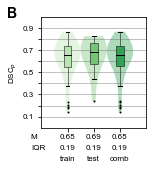

In [86]:
def box_violin(data, position, color, ax):

    if not isinstance(position, list):
        position = [position]
    #plot violin
    parts = ax.violinplot(data, positions=position, vert=True,
                showmeans=False, showmedians=False,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.4)

    # plot boxplot
    ax.boxplot(data, positions=position, vert=True,
               showmeans=False, meanline=False, patch_artist=True,
               boxprops=dict(facecolor=color, color='k', linewidth=0.5),
               medianprops=dict(color='k' ),
               whiskerprops=dict(linewidth=0.5),
               flierprops =dict(markersize=1, marker='o'),
               # meanprops=dict(color='k',linestyle = ':')
               )

def get_LARC_patients(file):
    df = pd.read_csv(file)
    d = df.loc[df['patient_ids'] < 1000]['f1_score']
    s = d.describe()
    
    M = s['50%']
    IQR = s['75%']-s['25%']
    
    return d.to_list(), M, IQR, 


# Test set
fig, ax = plt.subplots(1,1, figsize= (5*cm , 6*cm))
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.99, top=0.90, wspace=None, hspace=None)

src = 'D:\BiGART_results'

data = [['train', '#bae4b3' , get_LARC_patients(os.path.join(src, 'bigart_115_116_117_118_119_patient.csv'))] ,
        ['test',  '#74c476',   get_LARC_patients(os.path.join(src, 'voted_testset_LARC_115.csv'))],
       ]

data.append(['comb', '#31a354', (data[0][2][0]+ data[1][2][0], None, None)])


positions = [0.5,1,1.5]
for (t, c, (d, m, i)), p in zip(data, positions):
    box_violin(d, p, c, ax)
    if not m:
        m = np.median(d)
        i = np.quantile(d, 0.75) - np.quantile(d, 0.25)

        
    ax.text(p, -0.1, '{:.02}'.format(m), ha='center')
    ax.text(p, -0.2, '{:.02}'.format(i), ha='center')
    ax.text(p, -0.3, t, ha='center')

ax.text(-0.2,-0.1, 'M',ha='left')
ax.text(-0.2,-0.2, 'IQR',ha='left')

ax.set(ylim=[0,1], 
       ylabel='DSC$_p$',
       yticks=[0.1*i for i in range(1,10)],
       yticklabels=[0.1, '', 0.3, '', 0.5 , '', 0.7, '', 0.9],
       xticklabels=[]
      )    
ax.grid(which='major', color='#666666', linestyle='-', axis='y', alpha=0.5)

plt.text(-0.65, 0.99, 'B', fontweight='bold', fontsize=14)

plt.savefig('..\Paper_2\gfx\Fig_3B.png', dpi=300, facecolor='white')
    


,patient_ids,f1_score
0,1113.0,0.545048
1,1120.0,0.764314
2,1121.0,0.860276
3,1133.0,0.837702
4,1138.0,0.750080
...,...,...
158,66.0,0.178885
159,76.0,0.487961
160,77.0,0.651712
161,89.0,0.549103
